In [1]:
import numpy as np
import tensorflow.keras.backend as K
import tensorflow as tf

from tensorflow import keras
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input, Conv1D, MaxPooling1D, BatchNormalization, Flatten, Dense, Average, Dropout, SpatialDropout1D
from keras.utils import plot_model

ModuleNotFoundError: No module named 'tensorflow'

In [4]:
dataset = np.load("../../KEMDy20_v1_1/Extract/Dataset_MFCC.npz", allow_pickle=True)

In [5]:
train_x = dataset["train_x"]
train_y = dataset["train_y"]
test_x = dataset["test_x"]
test_y = dataset["test_y"]

In [4]:
def Macro_f1(y_true, y_pred):
    y_true = K.round(y_true)
    y_pred = K.round(y_pred)
    
    tp = K.sum(y_true * y_pred, axis=0)
    fp = K.sum((1-y_true) * y_pred, axis=0)
    fn = K.sum(y_true * (1-y_pred), axis=0)
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    f1 = 2 * precision * recall / (precision + recall + K.epsilon())
    
    # Calculate macro F1 score
    macro_f1 = K.mean(f1)
    
    return macro_f1

In [6]:
# 레이블 인코딩
le = LabelEncoder()
le.fit(train_y)
encoded_train_y = le.transform(train_y)

# 원핫 인코딩
onehot_train_y = to_categorical(encoded_train_y)

# train_y에서 사용된 LabelEncoder 객체를 그대로 사용하여 test_y 인코딩
encoded_test_y = le.transform(test_y)

# test_y를 원핫 인코딩
onehot_test_y = to_categorical(encoded_test_y)

NameError: name 'to_categorical' is not defined

In [6]:
model_count = 4

# Split the train and test data into four parts
train_data_parts = np.split(train_x, model_count, axis=1)
test_data_parts = np.split(test_x, model_count, axis=1)

In [7]:
# Define submodel architecture
def create_submodel(input_shape):
    submodel_input = Input(shape=input_shape)
    x = Conv1D(filters=32, kernel_size=3, activation='relu')(submodel_input)
    x = MaxPooling1D(pool_size=2)(x)
    x = BatchNormalization()(x)
    x = Conv1D(filters=64, kernel_size=3, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = BatchNormalization()(x)
    x = Conv1D(filters=128, kernel_size=3, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(units=256, activation='relu')(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(units=7, activation='softmax')(x)
    return submodel_input, x

# Define the list to store submodels and input shapes
submodels = []
input_shapes = []

# Create submodels
for i in range(model_count):
    input_shape = train_data_parts[i].shape[1:]
    submodel_input, submodel_output = create_submodel(input_shape)
    submodels.append(Model(inputs=submodel_input, outputs=submodel_output))
    input_shapes.append(input_shape)

# Define final model architecture
inputs = [Input(shape=input_shape) for input_shape in input_shapes]
outputs = [[submodel(inputs[i])] for i, submodel in enumerate(submodels)]
merged = Average()([output[0] for output in outputs])

#merged = Dense(units=7, activation='softmax')(Flatten()(merged))
final_model = Model(inputs=inputs, outputs=merged)

# Compile the final model
final_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[Macro_f1])

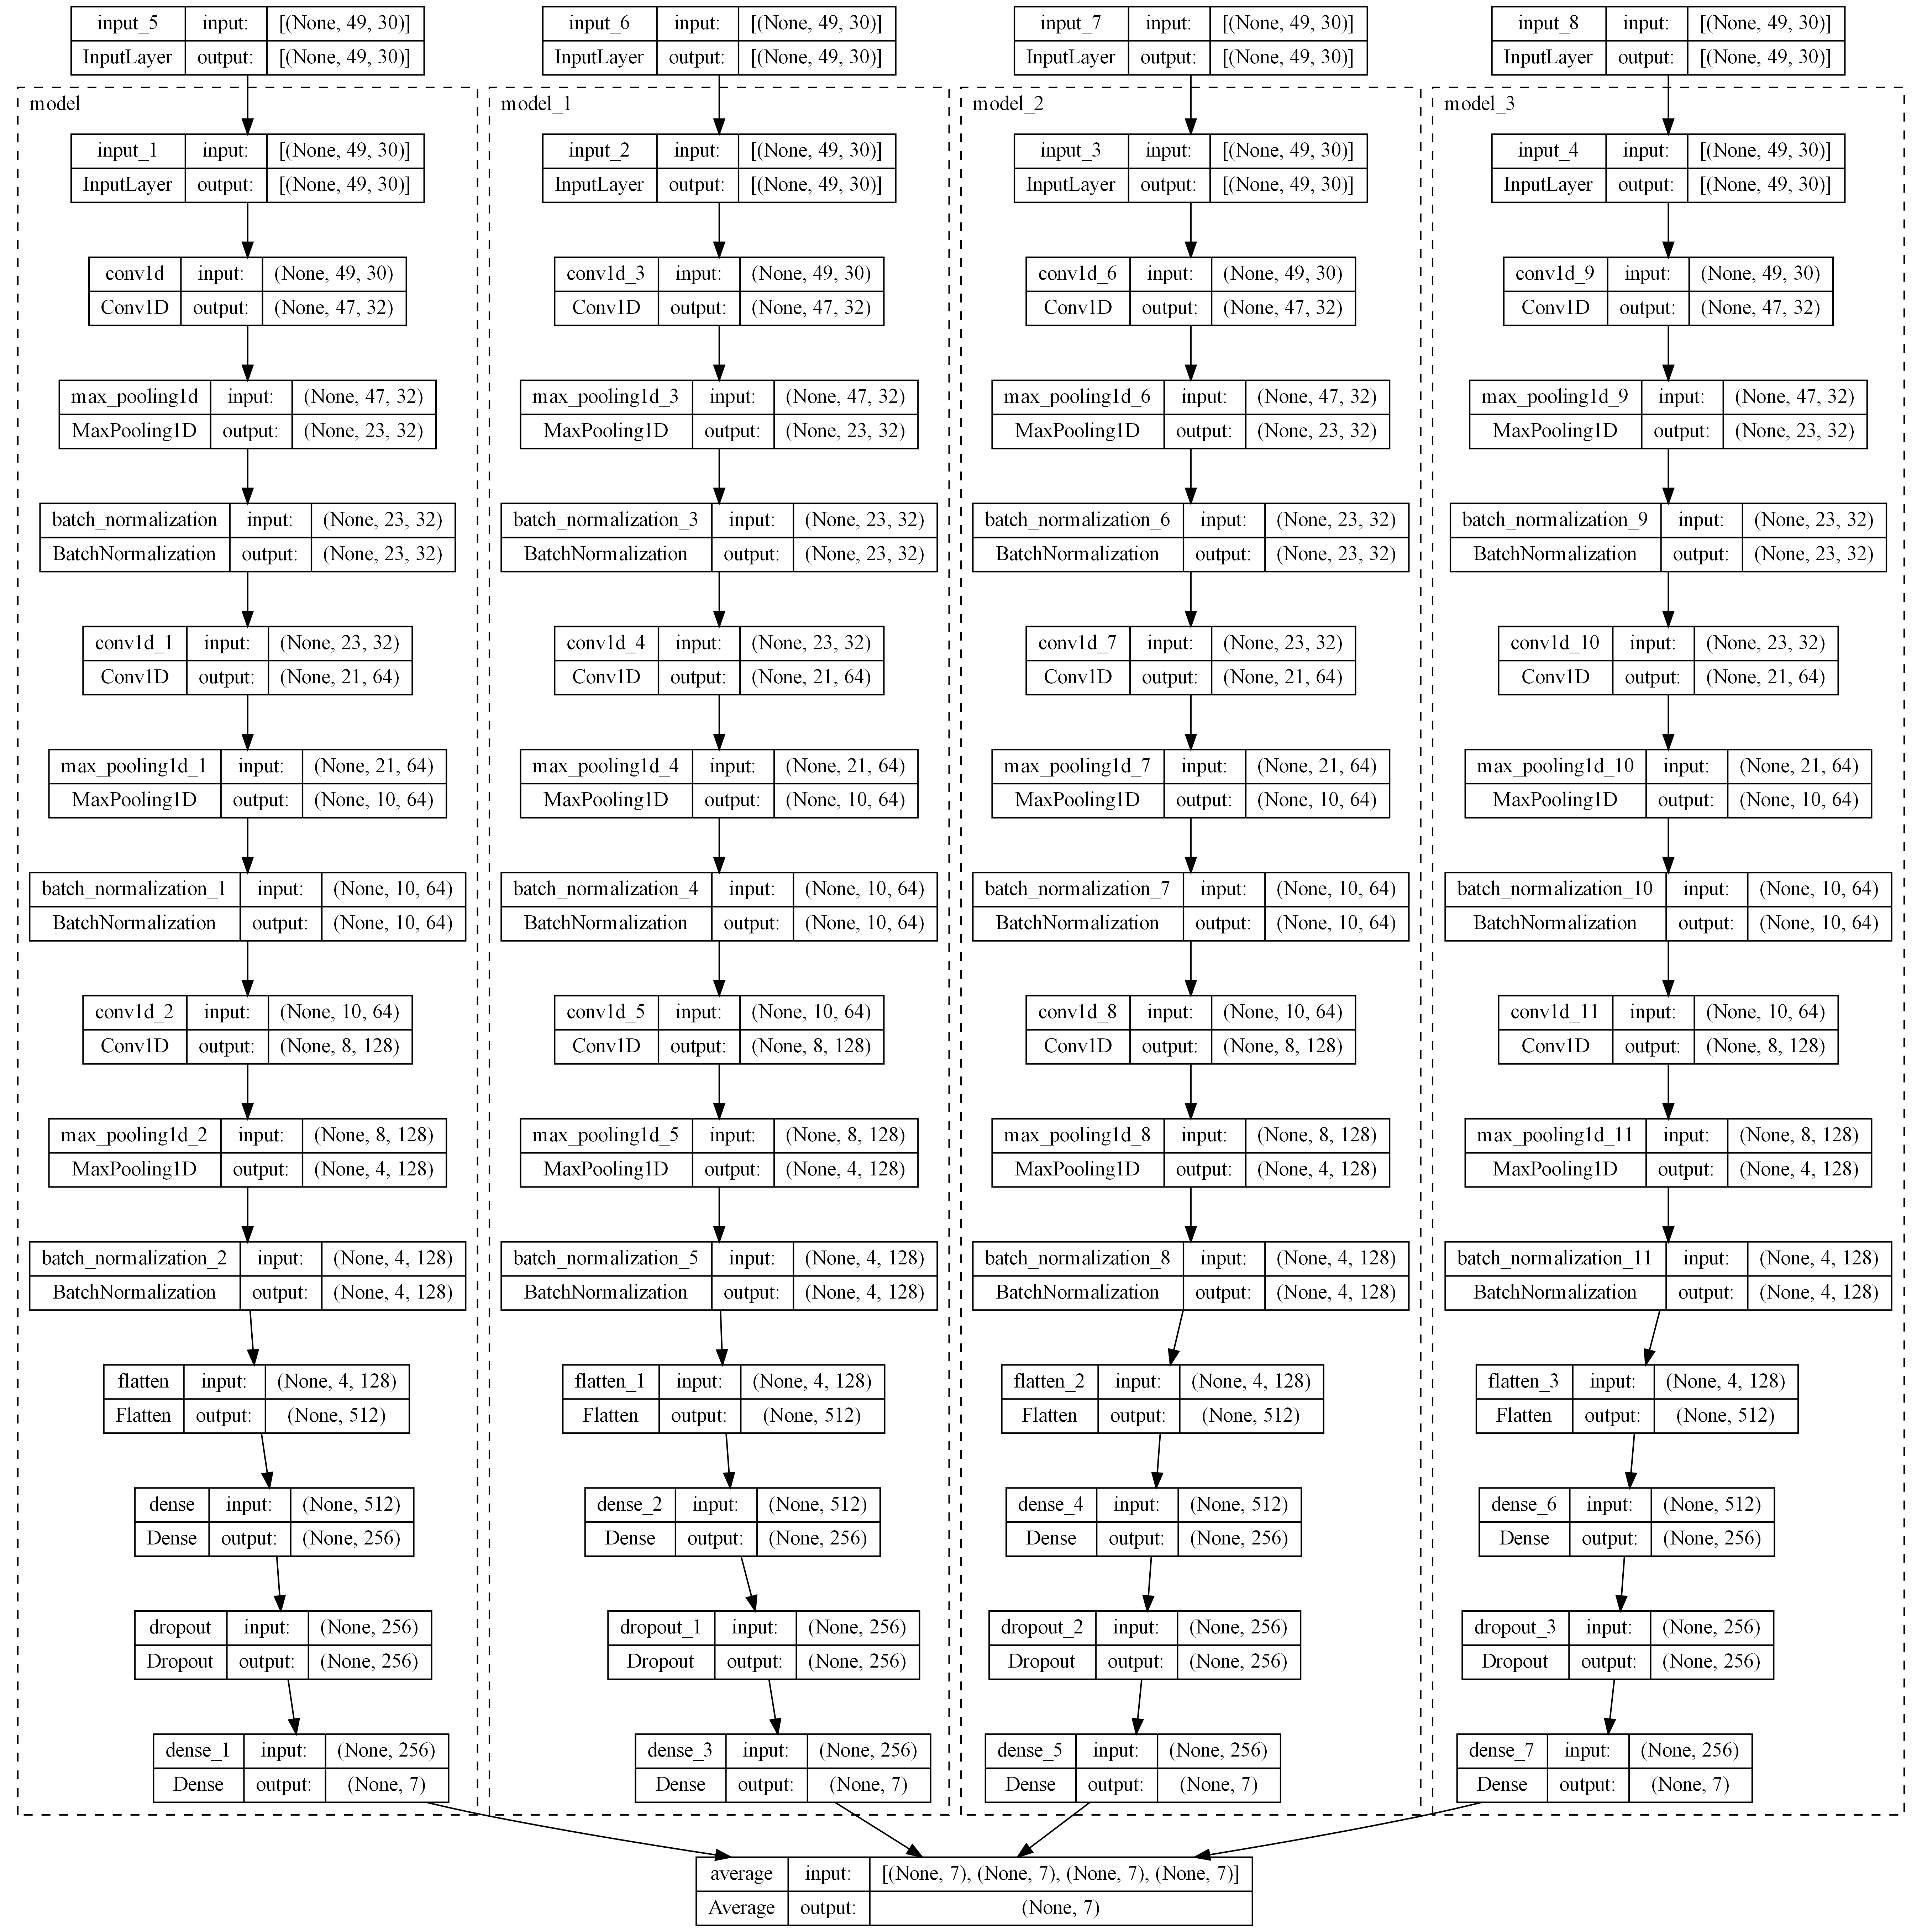

In [8]:
# Visualize final model architecture
plot_model(final_model, to_file='../final_model.png', show_shapes=True, expand_nested=True, dpi=300)

In [17]:
import os
from tensorflow.keras import callbacks

# Prepare the data for training
final_train_data = [train_data_parts[i].reshape(train_x.shape[0], -1, train_x.shape[2]) for i in range(model_count)]
final_test_data = [test_data_parts[i].reshape(test_x.shape[0], -1, test_x.shape[2]) for i in range(model_count)]

save_model_path="../Model/"
weight_path=save_model_path+"Model_weights_best_count"+str(model_count)+".hdf5"

if not os.path.exists(save_model_path):
    os.mkdir(save_model_path)

checkpoint = callbacks.ModelCheckpoint(
    weight_path,
    monitor='val_loss',
    verbose=1,
    save_weights_only=True,
    save_best_only=True
)

In [18]:
# Train the final model
final_model.fit(
    final_train_data,
    onehot_train_y,
    epochs=100,
    batch_size=32,
    validation_data=(final_test_data, onehot_test_y),
    callbacks=[checkpoint]
)

# Evaluate the final model on the test data
test_loss, test_macro_f1 = final_model.evaluate(final_test_data, onehot_test_y)
print(f'Test loss: {test_loss}, test macro_f1: {test_macro_f1}')

Epoch 1/100
809/810 [============================>.] - ETA: 0s - loss: 1.4986 - Macro_f1: 0.1166
Epoch 1: val_loss improved from inf to 1.42783, saving model to ../Model\Model_weights_best_count4.hdf5
810/810 [==============================] - 31s 28ms/step - loss: 1.4987 - Macro_f1: 0.1165 - val_loss: 1.4278 - val_Macro_f1: 0.0544
Epoch 2/100
810/810 [==============================] - ETA: 0s - loss: 1.3647 - Macro_f1: 0.1184
Epoch 2: val_loss improved from 1.42783 to 1.40830, saving model to ../Model\Model_weights_best_count4.hdf5
810/810 [==============================] - 22s 27ms/step - loss: 1.3647 - Macro_f1: 0.1184 - val_loss: 1.4083 - val_Macro_f1: 0.0527
Epoch 3/100
808/810 [============================>.] - ETA: 0s - loss: 1.3293 - Macro_f1: 0.1196
Epoch 3: val_loss improved from 1.40830 to 1.39973, saving model to ../Model\Model_weights_best_count4.hdf5
810/810 [==============================] - 22s 27ms/step - loss: 1.3293 - Macro_f1: 0.1197 - val_loss: 1.3997 - val_Macro_f

KeyboardInterrupt: 

In [19]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

final_model.load_weights(weight_path)
best_eva_list = final_model.evaluate(final_test_data, onehot_test_y)
loss = best_eva_list[0]
macro_f1 = best_eva_list[1]
print('Model evaluation: ', best_eva_list)
y_pred_best = final_model.predict(final_test_data)
em = classification_report(
    np.argmax(onehot_test_y,axis=1),
    np.argmax(y_pred_best,axis=1),
    target_names=le.classes_,
    output_dict=True
)
print(classification_report(np.argmax(onehot_test_y,axis=1), np.argmax(y_pred_best,axis=1), target_names=le.classes_))

198/198 [==============================] - 2s 10ms/step - loss: 1.3015 - Macro_f1: 0.1059
Model evaluation:  [1.3014824390411377, 0.10588014125823975]
198/198 [==============================] - 2s 8ms/step
              precision    recall  f1-score   support

       angry       0.29      0.32      0.30       664
     disqust       0.33      0.22      0.26       470
        fear       0.29      0.06      0.10       291
       happy       0.36      0.46      0.41      1128
     neutral       0.74      0.82      0.77      2741
         sad       0.35      0.29      0.32       629
    surprise       0.42      0.16      0.23       389

    accuracy                           0.53      6312
   macro avg       0.39      0.33      0.34      6312
weighted avg       0.51      0.53      0.51      6312



In [20]:
final_model.load_weights(weight_path)
best_eva_list = final_model.evaluate(final_train_data, onehot_train_y)
loss = best_eva_list[0]
macro_f1 = best_eva_list[1]
print('Model evaluation: ', best_eva_list)
y_pred_best = final_model.predict(final_train_data)
em = classification_report(
    np.argmax(onehot_train_y,axis=1),
    np.argmax(y_pred_best,axis=1),
    target_names=le.classes_,
    output_dict=True
)
print(classification_report(np.argmax(onehot_train_y,axis=1), np.argmax(y_pred_best,axis=1), target_names=le.classes_))

810/810 [==============================] - 8s 10ms/step - loss: 0.9835 - Macro_f1: 0.1480
Model evaluation:  [0.9835360646247864, 0.14796137809753418]
810/810 [==============================] - 7s 8ms/step
              precision    recall  f1-score   support

       angry       0.49      0.50      0.50      2743
     disqust       0.55      0.37      0.44      1912
        fear       0.68      0.22      0.34      1138
       happy       0.47      0.59      0.52      4603
     neutral       0.81      0.89      0.85     11632
         sad       0.51      0.45      0.48      2340
    surprise       0.68      0.34      0.46      1522

    accuracy                           0.66     25890
   macro avg       0.60      0.48      0.51     25890
weighted avg       0.66      0.66      0.64     25890



In [7]:
#from sklearn.manifold import TSNE
#import matplotlib.pyplot as plt

#tsne = TSNE(n_components=2, random_state=0)
#digits_tsne = tsne.fit_transform(train_aug_x)

In [8]:
#plt.figure(figsize=(10, 8))
#plt.scatter(digits_tsne[:, 0], digits_tsne[:, 1])
#plt.colorbar()
#plt.show()